## Algoritmo de árbol de búsqueda cuántico
A continuación se presenta un ejemplo del algoritmo cuántico de arbol de búsqueda que resuelve el juego de 3-puzzle en python. Para ello nos basamos en el trabajo de Andreas Wichert en *Quantum Tree Search with Qiskposicion_inicialt* [1](https://doi.org/10.3390/math10173103)

### Rompecabezas 3-puzzle
El rompecabezas de 3 se compone de tres fichas móviles numeradas en un marco de 2x2. Una celda del marco está vacía, y debido a esto los mosaicos se pueden mover para formar diferentes patrones. El objetivo es encontrar una serie de movimientos de fichas en el espacio en blanco que cambie el tablero de la configuración inicial a la configuración deseada. 
En el esquema de 2x2 hay 12 configuraciones posibles, para cualquier configuración solo hay dos movimientos posibles, en el sentido horario y antihorario.
La abstracción al modelo cuántico del puzzle consta de manejar cada celda como 4 objetos diferentes, tres celdas de número y una celda vacía. Cada objeto se codifica como dos qubits y una configuración de los cuatro objetos se puede representar como el registro de 8 qubits que llamaremos $\ket{x}$.

En esta representación:

 - Descriptores de posición son fijos
 - Descriptores de clase se mueven
 
 Se deben cumplir dos requisitos:
 
 - Para un tablero dado, la configuración y una regla de producción determinan la nueva configuración del tablero.
 - Determinar si la configuración es la configuración objetivo.
 
Existen cuatro posibles posiciones de la celda vacía. La función $p$ (producciones) determina la nueva configuración y la entrada de la función $p$ consiste en la configuración actual y un bit m que indica la dirección del movimiento $m=0$ sentido horario y $m=1$ sentido antihorario.
Existen 8 posibles mapeos como salida de las producciones porque la celda vacía puede estar en 4 posiciones y puede cambiar a dos posibles movimientos por cada 4 posiciones. Esto se representa como una matriz $L$ que actúa sobre el ket $\ket{m}$ que representa la dirección y el ket $\ket{x}$ de 8 qubits que representa el estado de la tabla.
$L \ket{m}\ket{x} = \ket{m}\ket{\gamma}$

La función $O$ definida como *oráculo* determina si la confuguración es nuestra configuración final deseada. Se define como un operador unitario $T$ que actúa también en la configuración de 8 + 1 qubits, esta vez el ket adicional $\ket{c}$ es un qubit auxiliar.

#### Definiciones
El objeto 1 está representado por 00, 2 está representado por 01, 3 está representado por 10 y el espacio vacío x está representado por 11. se tienen entonces 8 qubits, véase la configuración siguiente:

![alt](config2puzzle.png)

Nótese que el orden de los bits que describen las posiciones de cada casilla se encuentra en un orden invertido que va de derecha a izquierda y de abajo a arriba. Por ejemlo siendo el orden ABCD, la celda B tiene las posiciones 2 y 3 solo que se muestra invertido de derecha a izquierda y se ve como un 3 2.

Comenzamos importando las bibliotecas necesarias e inicializando el modelo

In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import MCXGate

In [2]:
def posicion_inicial(qubits_i:tuple):
    """Crea un circuito cuántico de 8 qubits y aplica una compuerta X a los qubits en las posiciones indicadas. 
    El propósito del mismo es representar las posiciones iniciales de las celdas en el puzzle, esto viene a ser el ket x.
    
    args
        qubits_i: En esta tupla de 4 elementos se indican las posiciones de los qubits que serán inicializados como ket 1
    """
    qc = QuantumCircuit(8)
    # Preparación de los estados del 0 al 7
    qc.x(qubits_i[0])
    qc.x(qubits_i[1])
    qc.x(qubits_i[2])
    qc.x(qubits_i[3])
    qc.name = "init"
    return qc

##### Reglas
En la tarea de 3 rompecabezas, tenemos cuatro **reglas** diferentes definidas por la posición del espacio vacío. Cada una de las reglas tiene dos instancias, ya sea moviendo el espacio vacío en el sentido de las agujas del reloj o en el sentido contrario a las agujas del reloj. Reconocemos las cuatro reglas e indicamos la presencia de una regla mediante un qubit. Usamos cuatro qubits que indican la presencia de las cuatro reglas y las llamamos el **rastro**. Necesitamos el **rastro** representado por los cuatro qubits, debido a que no podemos eliminar la información y no podemos volver a calcular la salida descomputando rehaceríamos las reglas. Adicionalmente, requerimos una **bandera** representada por un qubit que nos indique si la regla con la instanciación correspondiente se puede ejecutar o no. Finalmente, necesitamos un qubit que represente el **descriptor de ruta** que estará presente por superposición usando una puerta de Hadamard. 

En primer lugar, la parte condicional de las reglas es implementada por la compuerta de Toffoli, llamada también ccx. Reconoce la posición del espacio vacío y lo indica configurando un qubit de los cuatro qubits del *rastro* a uno.

##### Ejecución de las Reglas
La ejecución de las reglas usa la puerta de Fredkin, también llamada puerta de intercambio controlado (CSWAP), utilizando la información de seguimiento y el descriptor de ruta configurando el qubit bandera (qubit 8) para indicar si la regla se va a ejecutar. El reinicio se realiza descomputando, repitiendo la operación para poner la bandera nuevamente en el estado cero. 

Cambiamos el descriptor de la ruta por la puerta NOT y ejecutamos la segunda instanciación de la regla dependiendo del valor de la traza; el ```qc.barrier()``` separará la representación en el circuito, dando como resultado el circuito cuántico indicado en la Figura.

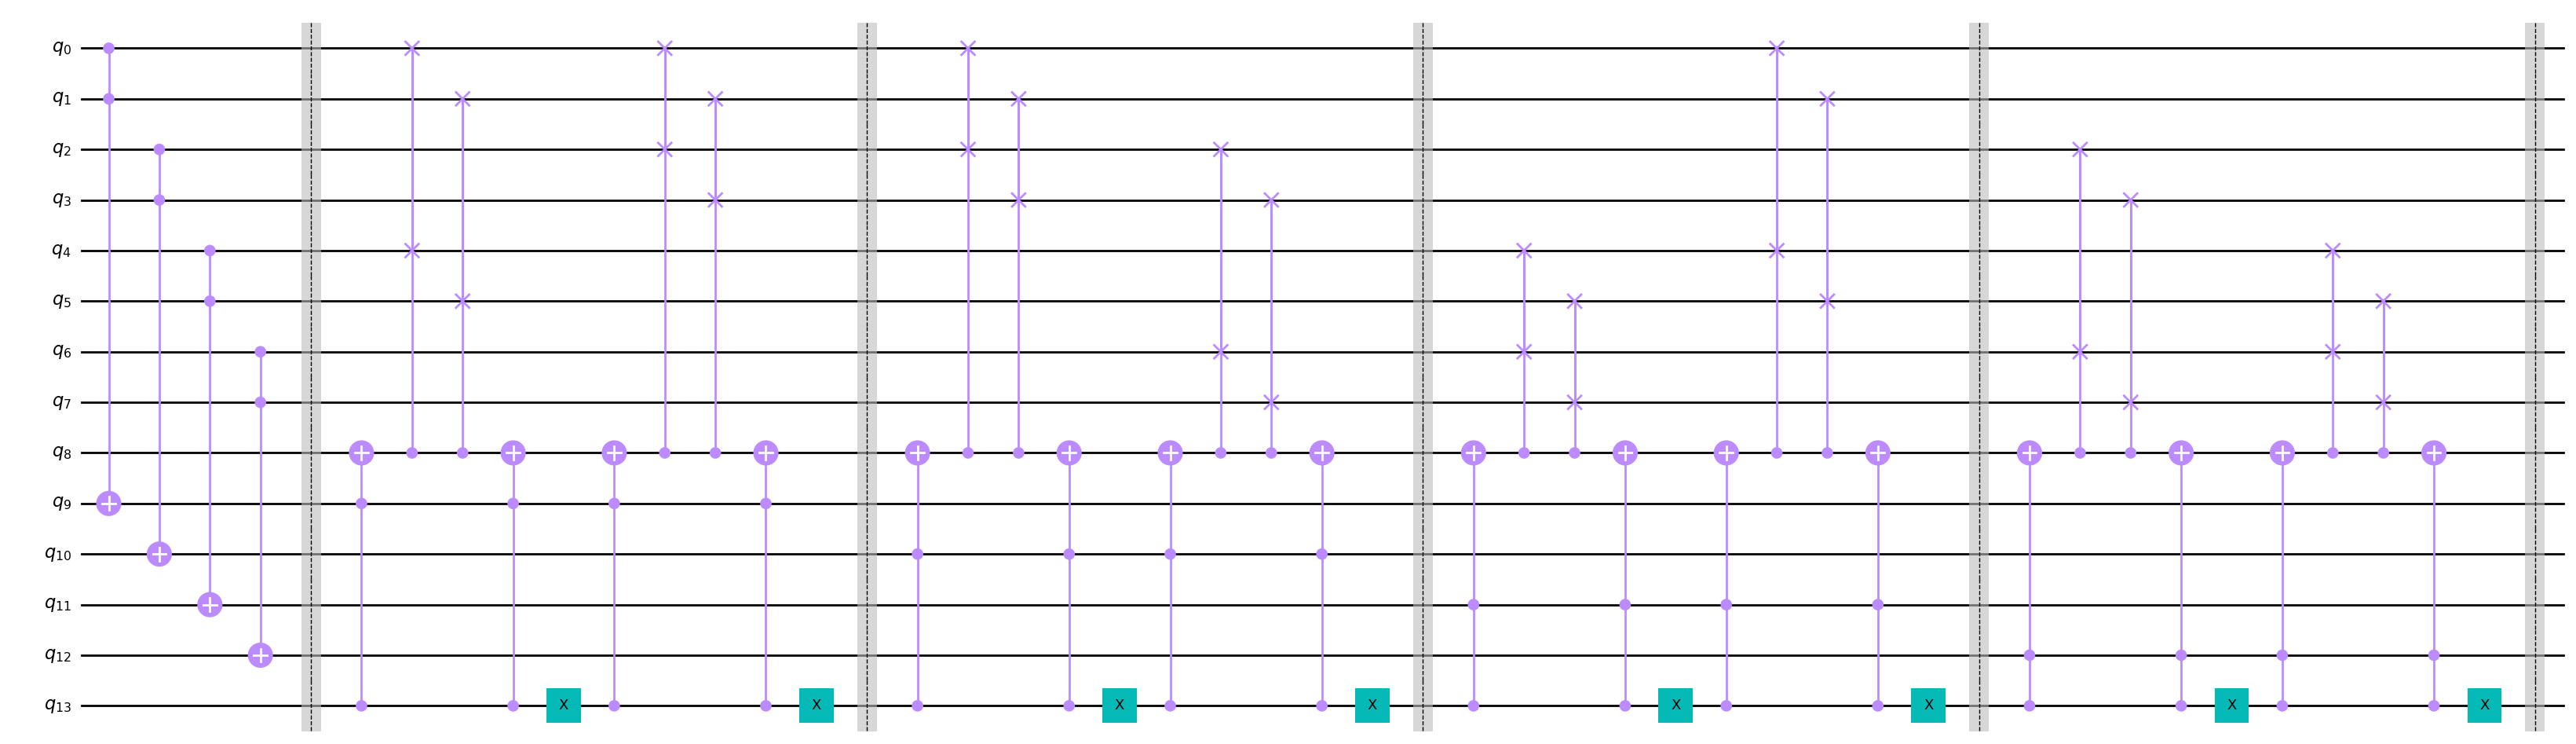

In [3]:
def reglas(nombre:str,tamaño:int, bandera:int, rastro:tuple, descriptor:int) -> QuantumCircuit:
    """Reglas de movimiento para el 3-puzzle
    
    args
        nombre: Nombre de las reglas
        tamaño: El valor define el tamaño del circuito. 
        bandera: (Posición) Indica si la regla puede ejecutarse o no. El valor define la posición de la bandera.
        rastro: (Posiciones) Cuatro qubits indican la ubicación de la celda vacía. El valor define la posición del rastro.
        descriptor: (Posición) El descriptor de camino indica el movimiento a realizar. El valor define la posición del descriptor.
    """
    qc = QuantumCircuit(tamaño)

    #If part of rules marked in trace
    qc.ccx(0,1,rastro[0])
    qc.ccx(2,3,rastro[1])
    qc.ccx(4,5,rastro[2])
    qc.ccx(6,7,rastro[3])
    qc.barrier()
    
    # Primer conjunto de reglas para la casilla A

    #Search empty state with the descriptor
    qc.ccx(rastro[0],descriptor,bandera)
    #Execute 1st then part by moving the empty space anti-clockwise
    qc.cswap(bandera,0,4)
    qc.cswap(bandera,1,5)
    #Secod then part with changed descriptor
    #Reset Flag
    qc.ccx(rastro[0],descriptor,bandera)
    #Fetch second superposition
    qc.x(descriptor)
    qc.ccx(rastro[0],descriptor,bandera)
    #Execute 2th then part by moving the empty space clockwise
    qc.cswap(bandera,0,2)
    qc.cswap(bandera,1,3)
    #Reset Flag
    qc.ccx(rastro[0],descriptor,bandera)
    #Restore descriptor
    qc.x(descriptor)
    qc.barrier()

    # Segundo conjunto de reglas para la casilla B

    #Search empty state with the descriptor
    qc.ccx(rastro[1],descriptor,bandera)
    #Execute 1st then part
    qc.cswap(bandera,0,2)
    qc.cswap(bandera,1,3)
    #Secod then part with changed descriptor
    #Reset Flag
    qc.ccx(rastro[1],descriptor,bandera)
    #Fetch second superposition
    qc.x(descriptor)
    qc.ccx(rastro[1],descriptor,bandera)
    #Execute 2th then part
    qc.cswap(bandera,2,6)
    qc.cswap(bandera,3,7)
    #Reset Flag
    qc.ccx(rastro[1],descriptor,bandera)
    #Restore descriptor
    qc.x(descriptor)
    qc.barrier()

    # Tercer conjunto de reglas para la casilla C

    #Search empty state with the descriptor
    qc.ccx(rastro[2],descriptor,bandera)
    #Execute 1st then part
    qc.cswap(bandera,4,6)
    qc.cswap(bandera,5,7)
    #Secod then part with changed descriptor
    #Reset Flag
    qc.ccx(rastro[2],descriptor,bandera)
    #Fetch second superposition
    qc.x(descriptor)
    qc.ccx(rastro[2],descriptor,bandera)
    #Execute 2th then part
    qc.cswap(bandera,0,4)
    qc.cswap(bandera,1,5)
    #Reset Flag
    qc.ccx(rastro[2],descriptor,bandera)
    #Restore descriptor
    qc.x(descriptor)
    qc.barrier()

    # Cuarto conjunto de reglas para la casilla D

    #Search empty state with the descriptor
    qc.ccx(rastro[3],descriptor,bandera)
    #Execute 1st then part
    qc.cswap(bandera,2,6)
    qc.cswap(bandera,3,7)
    #Secod then part with changed descriptor
    #Reset Flag
    qc.ccx(rastro[3],descriptor,bandera)
    #Fetch second superposition
    qc.x(descriptor)
    qc.ccx(rastro[3],descriptor,bandera)
    #Execute 2th then part
    qc.cswap(bandera,4,6)
    qc.cswap(bandera,5,7)
    #Reset Flag
    qc.ccx(rastro[3],descriptor,bandera)
    #Restore descriptor
    qc.x(descriptor)
    qc.barrier()
    qc.name = nombre
    
    # Se muestra la estructura del circuito en caso de querer visualizarla
    if nombre == 'test':
        display(
            qc.draw(output='mpl', fold=-1)
        )
    return qc

reglas(nombre="test",tamaño=14,bandera=8,rastro=(9,10,11,12),descriptor=13)

#### Profundidad 2
La amplificación de Grover no se puede aplicar a menos de cuatro estados. Una búsqueda de profundidad uno para el rompecabezas de 3 parte los resultados en dos estados y una búsqueda de profundidad dos en cuatro estados. El operador $L(2)$ que describe la búsqueda de la profundidad dos se representa como

$L(2) \ket{m_2 , m_1}\ket{x} = \ket{m_2 , m_1}\ket{\gamma}$

con dos qubits representando el camino que tomará.

El operador $T$ representa la función oráculo. La cual sirve para verificar si se ha alcanzado la solución.

Con búsqueda en profundidad $t = 2$, se necesitan cuatro qubits adicionales para representar la nueva traza, un qubit adicional para el descriptor de ruta de la profundidad dos y un qubit auxiliar para la operación del oráculo. El circuito cuántico para este caso está representado por 20 qubits. Medimos el descriptor de ruta representado por dos qubits 13 y 18.

En el ejemplo siguiente las variables init y goal definen la configuración inicial de las celdas del puzzle y la configuración objetivo, La siguiente imagen representa la posición inicial de las celdas en las configuraciones indicadas en el código.

![alt](Posicion-inicial.png)

La posición de los bits en 1 del registro de las cuatro celdas (los 8 bits que definen la posición de las celdas) es lo que define la configuración inicial y objetivo del puzzle. En este caso la configuración inicial es 2-3-4-7, y la objetivo es 0-4-5-7 la cual es llevar la celda vacía hasta la posición C en sentido antihorario.

![alt](Posicion-final1.png) 


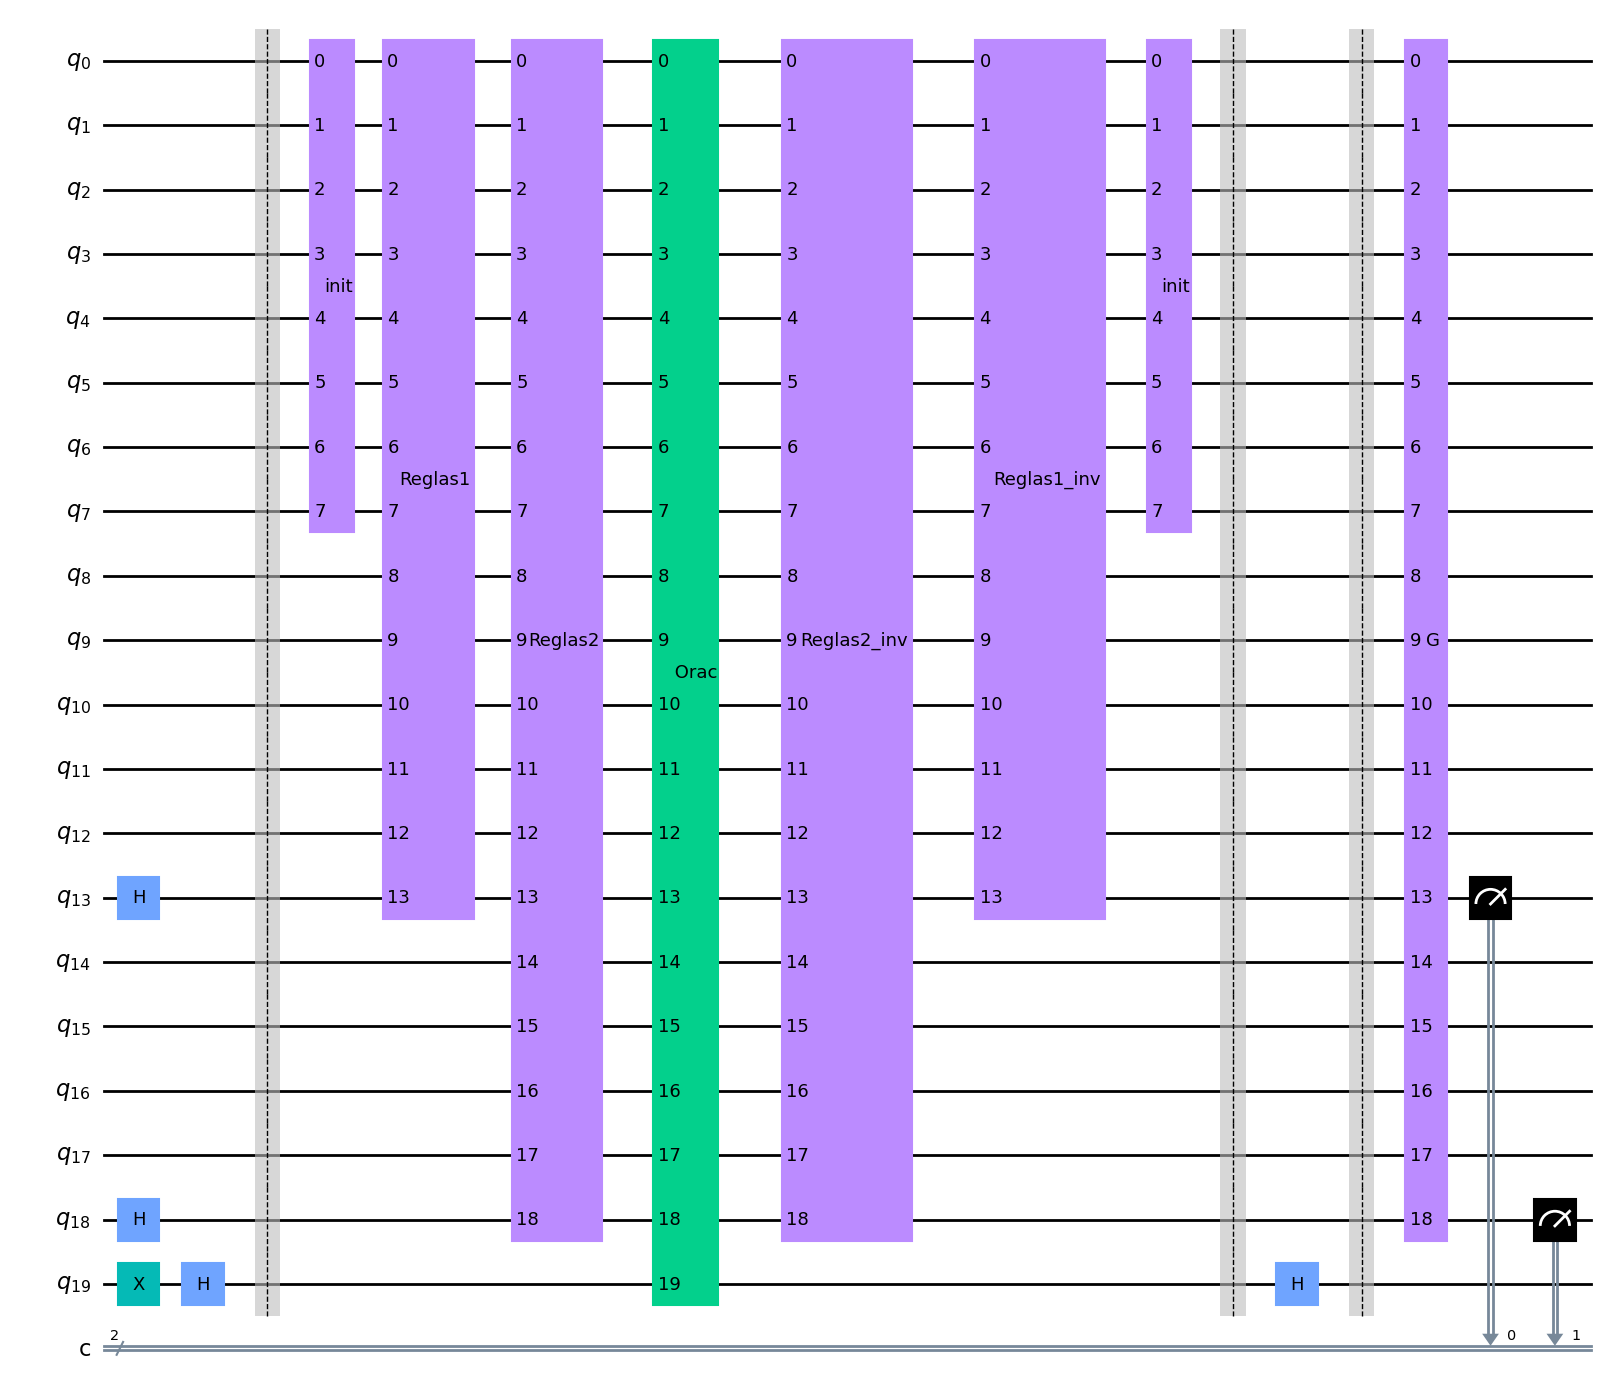

In [4]:
def oracle(size:int, qubits_t:tuple):
    """Oráculo. Verifica si se ha alcanzado la solución.
    
    args
        size: El tamaño en qubits del circuito
        qubits_t: Esta tupla define la solución (target) del puzzle por la posición de los qubits en 1.
    """
    qc = QuantumCircuit(size)
    gate = MCXGate(4)
    #Goal Configurations
    qc.append(gate,[qubits_t[0], qubits_t[1], qubits_t[2], qubits_t[3], size-1])
    qc.name=" Orac"
    return qc
    
def reglas_inv(nombre:str, tamaño:int, bandera:int, rastro:tuple, descriptor:int) -> QuantumCircuit:
    qc = reglas(nombre, tamaño, bandera, rastro, descriptor)
    qc_inv = qc.inverse()
    qc_inv.name = nombre + "_inv"
    return qc_inv

def Grover():
    """Grover para el caso de profundidad 2"""
    qc = QuantumCircuit(19)
    #Diffusor
    qc.h([13,18])
    qc.z([13,18])
    qc.cz(13,18)
    qc.h([13,18])
    qc.name="G"
    return qc
    
# Inicialización del circuito cuántico con 25 qubits.
qc2 = QuantumCircuit(20,2)
# Posición de las celdas inicial y final, descritas como la posición de los qubits que son ket 1
init = (2,3,4,7)
goal = (0,4,5,7)
# Colocamos en superposición los descriptores de camino 13, 18 y 23
qc2.h(13)
qc2.h(18)

# Qubit auxiliar que indica si se alcanzó la solución, se niega y se coloca en superposición
qc2.x(19)
qc2.h(19)
qc2.barrier()

# Preparación del estado inicial
qc2.append(posicion_inicial(init),range(8))
qc2.append(reglas(nombre="Reglas1",tamaño=14,bandera=8,rastro=(9,10,11,12),descriptor=13), range(14))
qc2.append(reglas(nombre="Reglas2",tamaño=19,bandera=8,rastro=(14,15,16,17),descriptor=18),range(19))
# Oráculo
qc2.append(oracle(20, goal),range(20))
qc2.append(reglas_inv(nombre="Reglas2",tamaño=19,bandera=8,rastro=(14,15,16,17),descriptor=18),range(19))
qc2.append(reglas_inv(nombre="Reglas1",tamaño=14,bandera=8,rastro=(9,10,11,12),descriptor=13), range(14))
# Rehacemos la preparación
qc2.append(posicion_inicial(init),range(8))
qc2.barrier()
# Rehacemos la superposición del qubit auxiliar
qc2.h(19)
qc2.barrier()
qc2.append(Grover(),range(19))
qc2.measure(13,0)
qc2.measure(18,1)


# Visualización del circuito
estilo = { "displaycolor": { " Orac": ["#03D08C", "#000000"] } }
display(
    qc2.draw(output='mpl', style=estilo)
)

Se puede apreciar en la gráfica que la solución para este caso es 11, es decir mover la casilla en sentido horario dos veces.

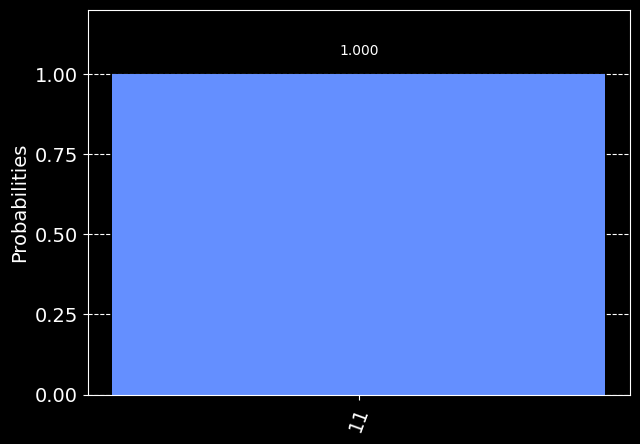

In [5]:
# Simulador 
simulator2 = Aer.get_backend('qasm_simulator')
result2=execute(qc2,simulator2, shots=512).result()
counts2 = result2.get_counts()
plot_histogram(counts2)

### Profundidad 3
Este caso es similar a los anteriores aunque el Grover es diferente.

En este ejemplo nuevamente las variables init y goal definen la configuración inicial de las celdas del puzzle y la configuración objetivo, esta vez la configuración objetivo por tratarse de 3 movimientos existen tres maneras de llegar a la configuración objetivo.

#### Configuración inicial y final
La configuración inicial es la misma que en el caso anterior 2-3-4-7, sin embargo la configuración final para este caso es 0-1-4-7, la cual puede apreciarse en la figura siguiente.

![alt](Posicion-final2.png)

Nótese que la solución se puede hallar con un solo movimiento al mover la celda vacía a la derecha, sin embargo en este caso se requiere una solución que consista estrictamente de tres movimientos.

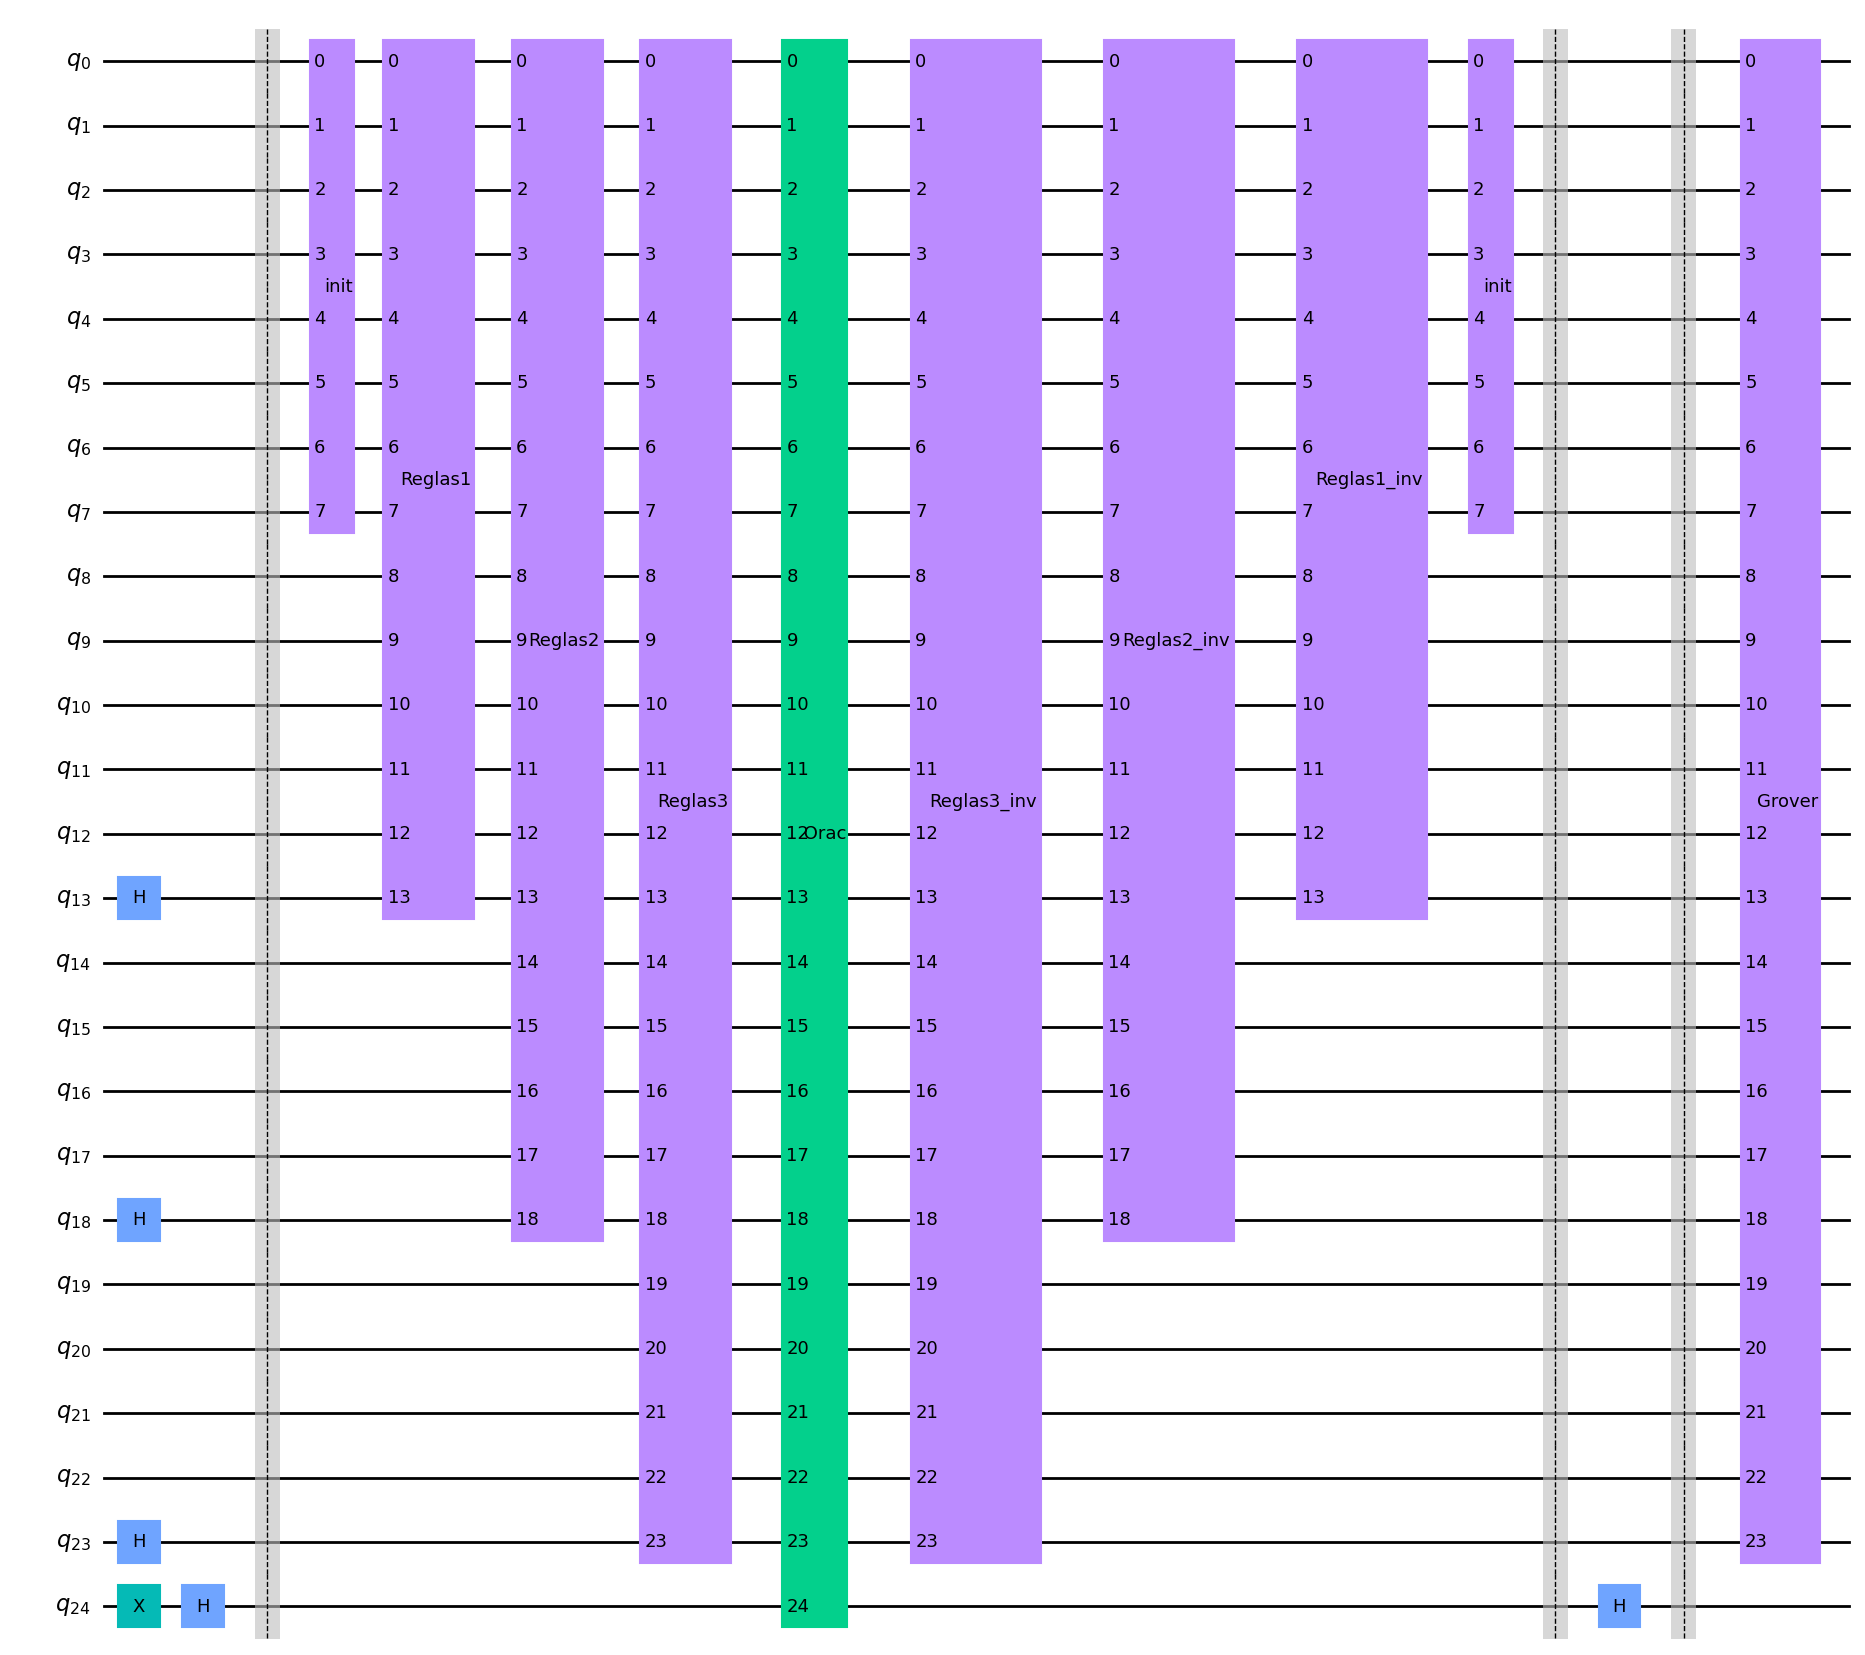

In [8]:
def Grover3():
    """Grover para el caso de profundidad 3. En términos generales, 
    el algoritmo de Grover se puede entender como una rotación en 
    el espacio de estado de los qubits que lleva la amplitud de la 
    solución deseada a un estado de mayor amplitud, lo que aumenta 
    la probabilidad de medir la solución correcta al final del algoritmo. """
    qc = QuantumCircuit(24)
    #Diffusor
    qc.h([13,18,23])
    qc.x([13,18,23])
    qc.h(13)
    qc.ccx(18,23,13)
    qc.h(13)
    qc.x([13,18,23])
    qc.h([13,18,23])
    qc.name="Grover"
    return qc

# Inicialización del circuito cuántico con 25 qubits.
qc3 = QuantumCircuit(25)
# Posición de las celdas inicial y final, descritas como la posición de los qubits que son ket 1
init = (2,3,4,7)
goal = (0,1,4,7)

# Colocamos en superposición los descriptores de camino 13, 18 y 23
qc3.h(13)
qc3.h(18)
qc3.h(23)

# Qubit auxiliar que indica si se alcanzó la solución, se niega y se coloca en superposición
qc3.x(24)
qc3.h(24)
qc3.barrier()

qc3.append(posicion_inicial(init),range(8))
qc3.append(reglas(nombre="Reglas1",tamaño=14,bandera=8,rastro=(9,10,11,12),descriptor=13), range(14))
qc3.append(reglas(nombre="Reglas2",tamaño=19,bandera=8,rastro=(14,15,16,17),descriptor=18),range(19))
qc3.append(reglas(nombre="Reglas3",tamaño=24,bandera=8,rastro=(19,20,21,22),descriptor=23),range(24))
# Oráculo con la solución
qc3.append(oracle(25, goal),range(25))
qc3.append(reglas_inv(nombre="Reglas3",tamaño=24,bandera=8,rastro=(19,20,21,22),descriptor=23),range(24))
qc3.append(reglas_inv(nombre="Reglas2",tamaño=19,bandera=8,rastro=(14,15,16,17),descriptor=18),range(19))
qc3.append(reglas_inv(nombre="Reglas1",tamaño=14,bandera=8,rastro=(9,10,11,12),descriptor=13), range(14))
# Rehacemos la preparación
qc3.append(posicion_inicial(init),range(8))
qc3.barrier()

qc3.h(24)
qc3.barrier()
qc3.append(Grover3(),range(24))

# Visualización del circuito
display(
    qc3.draw(output='mpl', fold=-1, style=estilo)
)


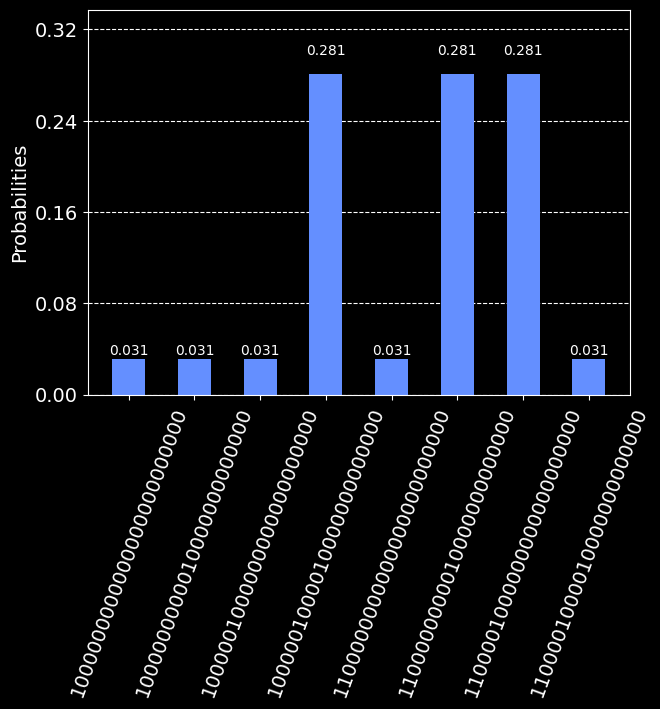

In [9]:
simulator3 = Aer.get_backend('statevector_simulator')
result3=execute(qc3,simulator3).result()
counts3 = result3.get_counts()
plot_histogram(counts3)

Puede apreciarse que 3 soluciones fueron encontradas para este caso, ya que alcanzar la configuración objetivo con tres movimientos exactos solo puede lograrse de tres formas diferentes, estas soluciones tienen como descriptor de camino los casos: 1-1-0, 1-0-1, 0-1-1, siendo 1 el movimiento en sentido horario y 0 antihorario, se puede analizar que las tres decisiones de camino conducen a la solución.